**Projet personnel de reconnaissance d'émotions humaine sur des visages**

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import tensorflow as tf
import cv2
import glob
import os
import pickle
import random
from PIL import Image

from typing import Union, Tuple
from skimage.transform import resize

import datasets
from datasets import load_dataset


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import mnist, fashion_mnist, cifar10
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img, ImageDataGenerator


from keras import Model
from keras import regularizers
from keras.utils import plot_model
from keras.models import Sequential
from keras.layers import (Input, Dense, Flatten, Reshape, Rescaling, Convolution2D, MaxPooling2D,
Dropout, RandomFlip, RandomCrop, Concatenate, AveragePooling2D, BatchNormalization, Activation,
Add, Convolution2DTranspose, Convolution1DTranspose, Resizing, RandomRotation)
from keras.optimizers import Adam, RMSprop, Adamax, SGD
from keras.losses import SparseCategoricalCrossentropy, MeanSquaredError, CategoricalCrossentropy
from tensorflow.keras.applications import VGG16, InceptionResNetV2
from keras.applications.resnet import ResNet50, preprocess_input
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.ensemble import IsolationForest
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA #non-supervisé, garde max variance
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis #supervisé, max variance mais essaie de garder une clasification
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split


In [2]:
data_dir_train = "./archive/train/"
emotions = ["angry", "disgust", "fear", "happy", "neutral", "sad", "surprise"]

In [3]:
nbr_emotion = {}
nbr_emotion_perc = {}
for emotion in emotions:
    nbr_emotion[emotion] = len(os.listdir(f"{data_dir_train}{emotion}"))
    nbr_emotion_perc[emotion] = len(os.listdir(f"{data_dir_train}{emotion}"))/28709
display(nbr_emotion)

{'angry': 3995,
 'disgust': 436,
 'fear': 4097,
 'happy': 7215,
 'neutral': 4965,
 'sad': 4830,
 'surprise': 3171}

In [120]:
labels_train = np.zeros(28709, dtype=int)
labels_train[3995:3995+436] = 1
labels_train[3995+436:3995+436+4097] = 2
labels_train[3995+436+4097:3995+436+4097+7215] = 3
labels_train[3995+436+4097+7215:3995+436+4097+7215+4965] = 4
labels_train[3995+436+4097+7215+4965:3995+436+4097+7215+4965+4830] = 5
labels_train[3995+436+4097+7215+4965+4830:3995+436+4097+7215+4965+4830+3171] = 6
labels_train

array([0, 0, 0, ..., 6, 6, 6])

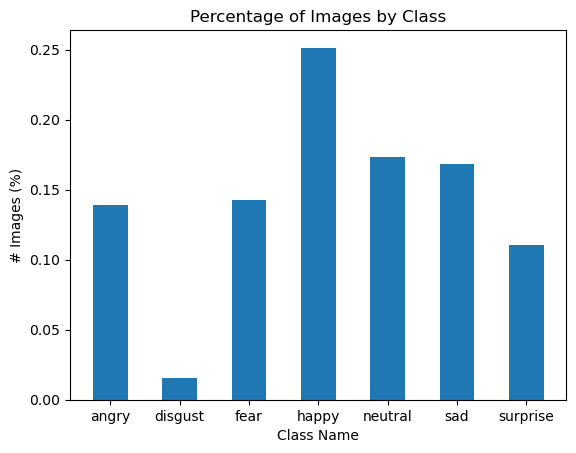

In [4]:
plt.bar(nbr_emotion_perc.keys(), nbr_emotion_perc.values(), width = .5);plt.title("Percentage of Images by Class");plt.xlabel('Class Name');plt.ylabel('# Images (%)')
plt.show()

**Exemple de boucle d'itération à tavers les différents dossiers**

In [5]:
data_dir_train = "./archive/train/"
emotions = ["angry", "disgust", "fear", "happy", "neutral", "sad", "surprise"]
for emotion in emotions:
    # Set image path
    file_path_type = [f"{data_dir_train}{emotion}/*.jpg"]
    display(file_path_type)


['./archive/train/angry/*.jpg']

['./archive/train/disgust/*.jpg']

['./archive/train/fear/*.jpg']

['./archive/train/happy/*.jpg']

['./archive/train/neutral/*.jpg']

['./archive/train/sad/*.jpg']

['./archive/train/surprise/*.jpg']

**Définir les catégories et afficher une image aléatoire de chacunes**

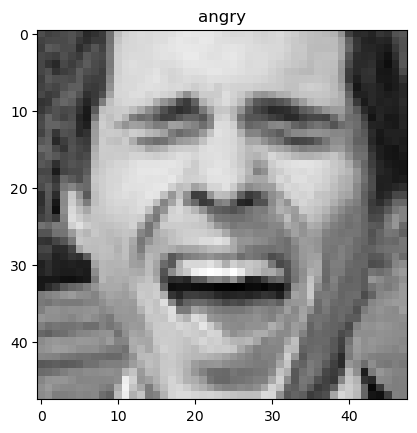

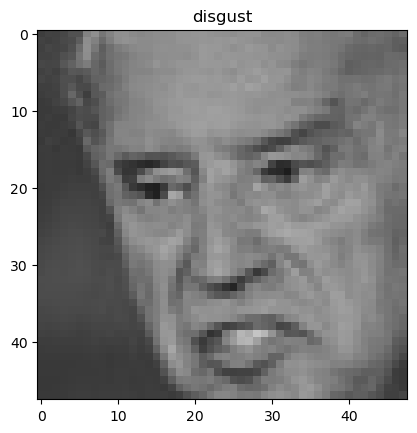

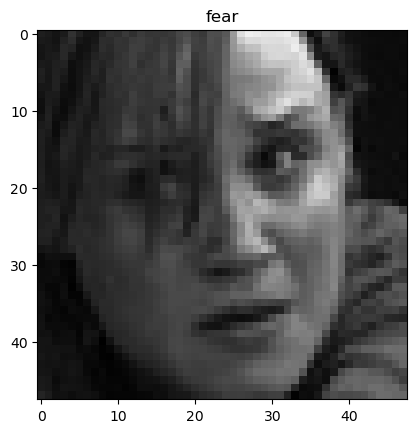

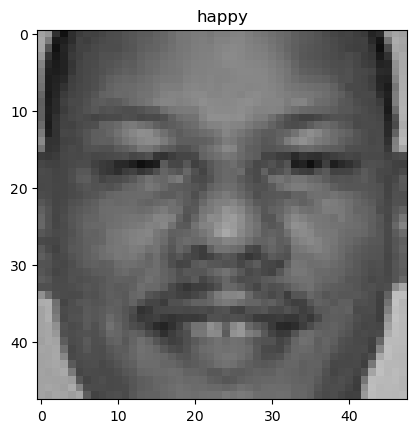

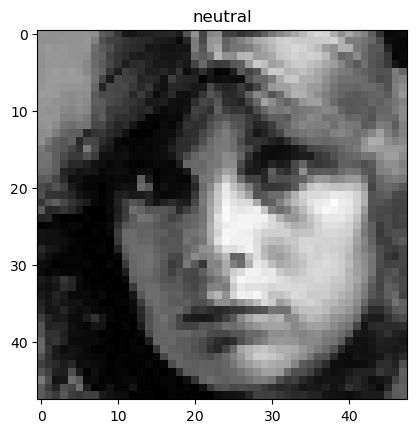

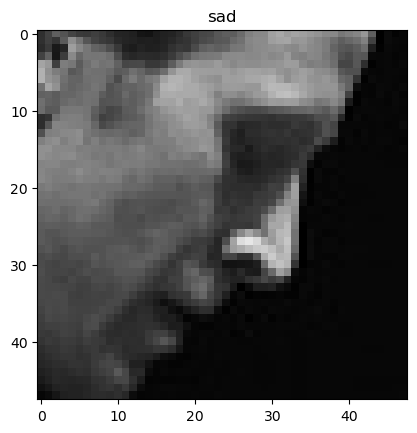

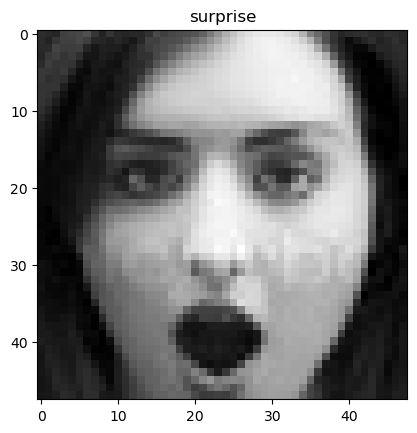

In [6]:
data_dir_train = "./archive/train/"
data_dir_test = "./archive/test/"
emotions = ["angry", "disgust", "fear", "happy", "neutral", "sad", "surprise"]
for emotion in emotions:
    # Set image path
    file_path_type = [f"{data_dir_train}{emotion}/*.jpg"] # Exemple : file_path_type = "./archive/train/angry/Training_3908.jpg"
    images = glob.glob(random.choice(file_path_type))
    random_image = random.choice(images)
    
    # Read input image:
    inputImage = cv2.imread(random_image)
    grayscaleImage = inputImage.copy()

    # Convert BGR to grayscale:
    # grayscaleImage = cv2.cvtColor(inputImage, cv2.COLOR_BGR2GRAY)
    plt.figure()
    plt.title(emotion)
    plt.imshow(grayscaleImage)

**Séparation dataset**

In [7]:
# train_ds = tf.keras.utils.image_dataset_from_directory(
# data_dir_train,
# validation_split=0.2,
# subset="training",
# seed=123,
# image_size=(48, 48),
# batch_size=64)

# test_ds = tf.keras.utils.image_dataset_from_directory(
# data_dir_test,
# validation_split=0.2,
# subset="validation",
# seed=123,
# image_size=(48, 48),
# batch_size=64)

**Automatisation de la création d'un dictionnaire de dataframes pour chaque émotions**

In [8]:
# d = {}
# for i in emotions:
#     data = []
#     for j in glob.glob(f"{data_dir_train}{i}/*.jpg", recursive=True):
#         data_unflatten = cv2.imread(j, cv2.IMREAD_GRAYSCALE)
#         data_flatten = data_unflatten.flatten()
#         data.append(data_flatten)
#     d["df_" + i] = pd.DataFrame(data)



**Sauvegarde du dictionnaire de dataframes pour chaque émotions**

In [9]:
# with open('dictionaire_df.pickle', 'wb') as handle:
#     pickle.dump(d, handle, protocol=pickle.HIGHEST_PROTOCOL)

**Sauvegarde de chaque dataframe de chaque émotions**

In [10]:
# for i in emotions:
#     d["df_" + i].to_csv(f"C:/Users/admindc/Documents/Projet_final/{'df_' + i}.csv", compression="zip")

**Chargement du dictionnaire de dataframes pour chaque émotions**

In [11]:
with open('dictionaire_df.pickle', 'rb') as handle:
    d = pickle.load(handle)

**Affichage des photos moyennes de chaque émotions**

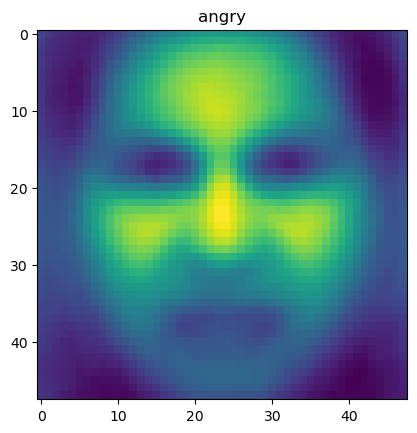

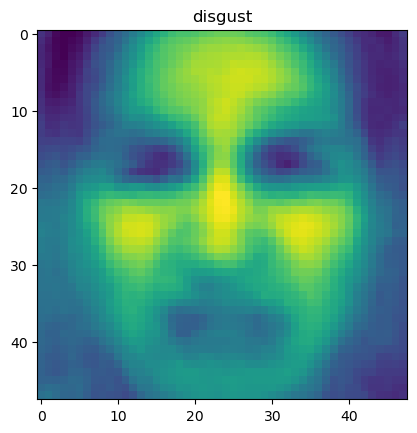

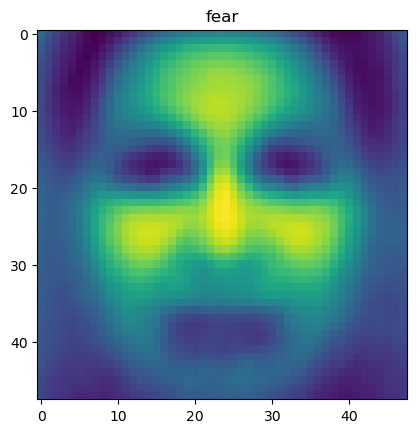

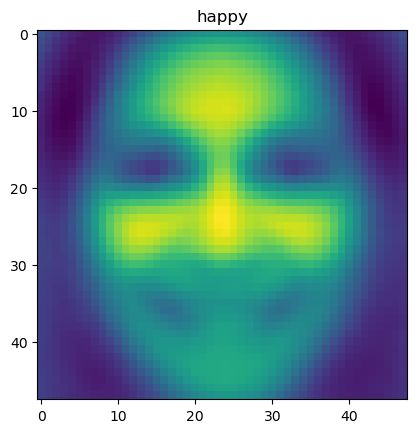

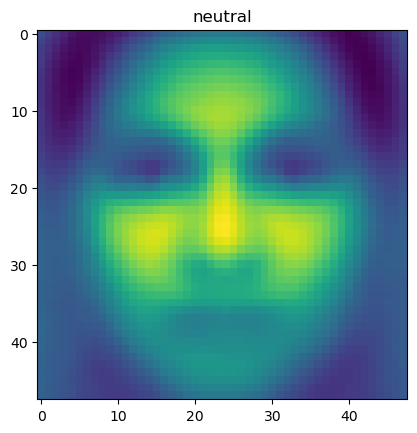

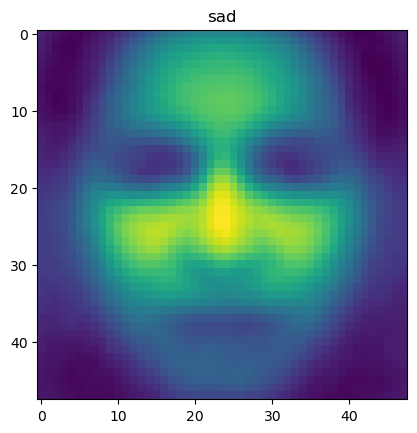

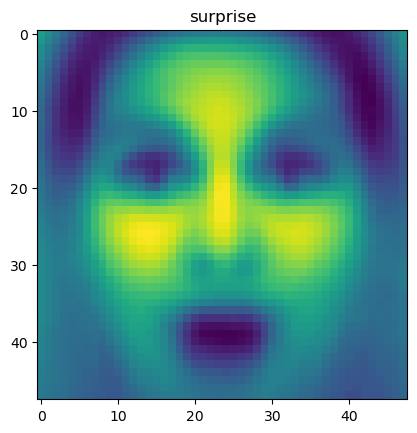

In [12]:
for i in emotions:
    series_obj = pd.Series(d[f"df_{i}"].mean())
    arr = series_obj.values
    reshaped_arr = arr.reshape((48, 48))
    plt.figure()
    plt.imshow(reshaped_arr)
    plt.title(i)

**Création dataframe global**

In [13]:
# data = []

# for i in glob.glob(f"{data_dir_train}**/*.jpg", recursive=True):
#     data_unflatten = cv2.imread(i, cv2.IMREAD_GRAYSCALE)
#     data_flatten = data_unflatten.flatten()
#     data.append(data_flatten)
# df=pd.DataFrame(data)


**Sauvegarde et chargement du dataframe global**

In [14]:
# df_train_tot = df.copy()
# df_train_tot.to_csv("C:/Users/admindc/Documents/Projet_final/df_tot_train.csv", compression="zip")

In [15]:
df_tot_train_load = pd.read_csv("C:/Users/admindc/Documents/Projet_final/df_tot_train.csv",compression="zip")
df_tot_train = df_tot_train_load.drop(['Unnamed: 0'], axis=1)

In [66]:
len(df_tot_train)

28709

array([0, 0, 0, ..., 0, 0, 0])

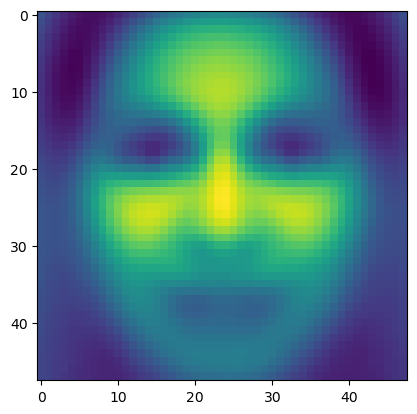

In [16]:
series_obj = pd.Series(df_tot_train.mean())
arr = series_obj.values
reshaped_arr = arr.reshape((48, 48))
plt.imshow(reshaped_arr)
plt.show()


**Recher d'anomalies parmmis les photos fain d'éliminer de potentiels outliers**

In [17]:
x = 0.01 # valeur abbérante tester 1%
IsFo = IsolationForest(contamination=x, random_state=42)

IsFo.fit(df_tot_train)

c:\Users\admindc\anaconda3\envs\tf_devia\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


IsolationForest(contamination=0.01, random_state=42)

In [18]:
In_Out = IsFo.predict(df_tot_train)
In_Out

array([ 1,  1, -1, ...,  1,  1,  1])

In [19]:
Is_Out = (In_Out == -1)
Is_Out.sum()

288

In [ ]:
df_anom = df_tot_train[Is_Out]
for i in range(len(df_anom)):
    series_obj = pd.Series(df_anom.iloc[i])
    arr = series_obj.values
    reshaped_arr = arr.reshape((48, 48))
    plt.imshow(reshaped_arr)
    plt.figure()


In [ ]:
df_tot_train

In [21]:
img_size = 48

In [22]:
train_datagen = ImageDataGenerator(#rotation_range = 180,
                                         width_shift_range = 0.1,
                                         height_shift_range = 0.1,
                                         horizontal_flip = True,
                                         rescale = 1./255,
                                         #zoom_range = 0.2,
                                         validation_split = 0.2
                                        )
validation_datagen = ImageDataGenerator(rescale = 1./255,
                                         validation_split = 0.2)

In [63]:
train_generator = train_datagen.flow_from_directory(directory = data_dir_train,
                                                    target_size = (img_size,img_size),
                                                    batch_size = 512,
                                                    color_mode = "grayscale",
                                                    class_mode = "categorical",
                                                    shuffle=True,
                                                    subset = "training"
                                                   )
validation_generator = validation_datagen.flow_from_directory( directory = data_dir_test,
                                                              target_size = (img_size,img_size),
                                                              batch_size = 512,
                                                              color_mode = "grayscale",
                                                              class_mode = "categorical",
                                                              shuffle = True,
                                                              subset = "validation"
                                                             )

Found 22968 images belonging to 7 classes.
Found 1432 images belonging to 7 classes.


In [64]:
model= tf.keras.models.Sequential()
model.add(Convolution2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(48, 48,1)))
model.add(Convolution2D(64,(3,3), padding='same', activation='relu' ))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Convolution2D(128,(5,5), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
    
# model.add(Convolution2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))

# model.add(Convolution2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))

model.add(Flatten()) 
model.add(Dense(32,activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
    
# model.add(Dense(512,activation = 'relu'))
# model.add(BatchNormalization())
# model.add(Dropout(0.25))

model.add(Dense(7, activation='softmax'))

model.compile(
    optimizer = Adam(lr=0.0001), 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
  )

In [61]:
epochs = 30
batch_size = 1024

In [ ]:
history = model.fit(x = train_generator,epochs = epochs,validation_data = validation_generator, batch_size=batch_size)

In [121]:
base_resnet = ResNet50(input_shape=(48, 48, 3), include_top=False)
for layer in base_resnet.layers[:30]:
    layer.trainable = False

inputs = Input((48,48,1))

x = Convolution2D(3, 1, 1, padding="same")(inputs)
x = preprocess_input(x)
x = base_resnet(x)

x = Flatten()(x)

x = Dense(50, activation="relu")(x)
x = Dense(10, activation="softmax")(x)

resnet = Model(inputs, x, name="resnet")

resnet.compile(optimizer=Adam(),
            loss = SparseCategoricalCrossentropy(),
            metrics=["accuracy"])

94765736/94765736 [==============================] - 6s 0us/step


In [ ]:
history = resnet.fit(df_tot_train, labels_train, validation_data=(df_tot_test, label_test), batch_size=512, epochs=10, validation_split=0.2)

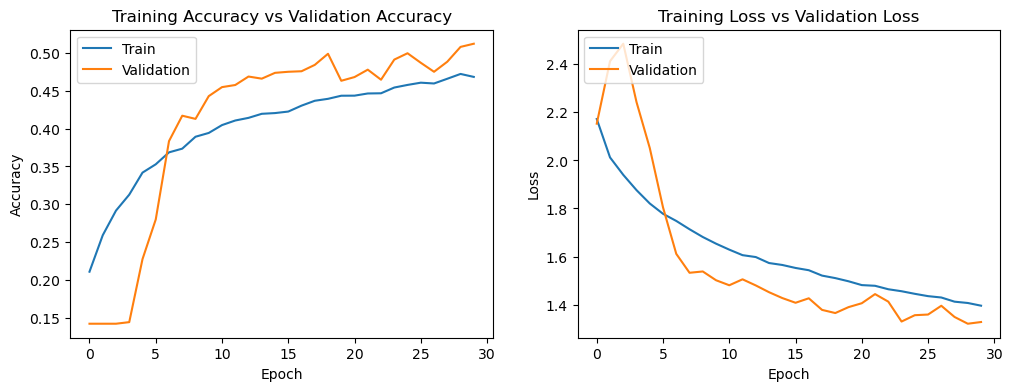

In [58]:
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
fig.set_size_inches(12,4)

ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Training Accuracy vs Validation Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc='upper left')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Training Loss vs Validation Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [59]:
model.save('model_optimal_with_shuffle_2.h5')

(48, 48)


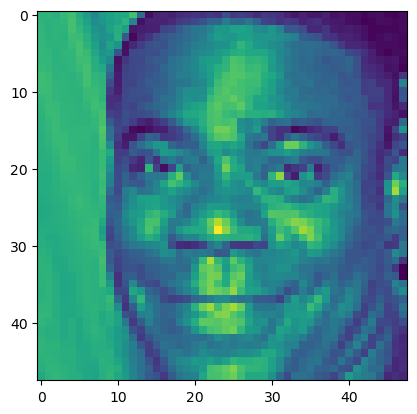

In [40]:
from keras.preprocessing import image
img = tf.keras.utils.load_img(f"{data_dir_test}happy/PrivateTest_95094.jpg",target_size = (48,48),color_mode = "grayscale")
img = np.array(img)
plt.imshow(img)
print(img.shape) #prints (48,48) that is the shape of our image

In [41]:
label_dict = {0:'Angry',1:'Disgust',2:'Fear',3:'Happy',4:'Neutral',5:'Sad',6:'Surprise'}

In [42]:
img = np.expand_dims(img,axis = 0) #makes image shape (1,48,48)
img = img.reshape(1,48,48,1)
result = model.predict(img)
result = list(result[0])
print(result)

1/1 [==============================] - 0s 298ms/step
[0.0, 0.0, 1.0, 4.3920166e-25, 0.0, 0.0, 3.472026e-10]


In [43]:
img_index = result.index(max(result))
print(label_dict[img_index])
plt.show()

Fear


In [44]:
train_loss, train_acc = model.evaluate(train_generator)
test_loss, test_acc   = model.evaluate(validation_generator)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_acc*100, test_acc*100))

23/23 [==============================] - 4s 167ms/step - loss: 1.1545 - accuracy: 0.5705
final train accuracy = 56.06 , validation accuracy = 57.05


In [ ]:
model.save_weights('model_weights.h5')

In [ ]:
# face = load_dataset("FastJobs/Visual_Emotional_Analysis", verbose=False)

In [ ]:
face.head()